# Overlaps analysis

In [1]:
# Imports 
from shutil import copyfile
import pybedtools
import os

import sklearn.metrics
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

from epitome.functions import *
from epitome.constants import *

In [2]:
all_pos_file = "/home/eecs/akmorrow/epitome/data/allTFs.pos.bed"
motif_path = "/home/eecs/akmorrow/epitome/motif_db"
output_dir = "/home/eecs/akmorrow/epitome/out/Overlaps"
deepsea_labels = "/data/akmorrow/epitome_data/deepsea_labels_train/"



In [3]:
# generated from original data by save_deepsea_label_data(deepsea_path) in functions.py
_, _, test_data = load_deepsea_label_data(deepsea_labels)

matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path='../../data/feature_name',eligible_assays = None,
                                  eligible_cells = None, min_cells_per_assay = 2, min_assays_per_cell=2)

In [4]:
# processed on s124 in dnases/Metrics/save_overlaps_results.py 
responses = np.load(os.path.join(output_dir, "responses.npy"))

# read response labels
factors = []
fp = open(os.path.join(output_dir, "responses_colnames.txt"))
for line in fp:
    tmp = line.split('_')
    factors.append(tmp[0])
fp.close()


In [5]:
unique_factors = set(factors)
unique_factors = list(filter(lambda x: x in list(assaymap), unique_factors))


In [6]:
# condense motif specific results to factor specific results
factor_arr = np.array(factors)

# holds TF specific results
factor_results = np.zeros([responses.shape[0], len(unique_factors)])

for i, factor in enumerate(unique_factors):
    
    # get all columns in response that are associated with factor
    idx = np.where(factor_arr == factor)[0]
    
    # set to 1 if at least 1 motif in a region is a hit
    factor_results[:,i] = np.amax(responses[:,idx], axis = 1)


In [7]:
# make dataframe to hold overlaps results
results_df_auc = pd.DataFrame(columns = ["CellType"] + unique_factors)
results_df_pr = pd.DataFrame(columns = ["CellType"] + unique_factors)

results_df_auc_only_peaks = pd.DataFrame(columns = ["CellType"] + unique_factors)
results_df_pr_only_peaks = pd.DataFrame(columns = ["CellType"] + unique_factors)

# save CTCF A549 for demonstration

CTCF_FPR = {}
CTCF_TPR = {}
CTCF_AUC = {}

for celltype in list(cellmap):
    print(celltype)
    
    ## For each cell type (64) mask by ATAC peaks (setting non-peaks in response to 0)
    # get dnase vector for this celltype 
    cell_mask = test_data["y"][matrix[cellmap[celltype],assaymap["DNase"]], ]
    cell_mask = cell_mask[0:int(len(cell_mask)/2)] # repeats itself twice
    cell_mask = np.matrix(cell_mask).T # make into column
    
    # tile mask
    tiled = np.tile(cell_mask, (1,factor_results.shape[1]))
    
    assert(tiled.shape == factor_results.shape)

    # mask results by DNase for this cell type
    preds = np.copy(factor_results)
    preds[tiled == 0] = 0
    
    masked_preds = np.copy(factor_results)
    preds[tiled == 0] = 0
    
    cell_pr = [celltype]
    cell_auc = [celltype]
    
    cell_pr_masked = [celltype]
    cell_auc_masked = [celltype]
    
    
    for i, factor in enumerate(unique_factors):
        
        matrix_idx = matrix[cellmap[celltype],assaymap[factor]]
                            
        if (matrix_idx == -1):
            cell_auc.append(np.NAN)
            cell_pr.append(np.NAN)
            
            cell_auc_masked.append(np.NAN)
            cell_pr_masked.append(np.NAN)
                            
        else:
        
            truth = test_data["y"][matrix_idx, :] 
            
            truth = truth[0:int(len(truth)/2)]

            # calculate metrics 
            try:
                cell_auc.append(sklearn.metrics.roc_auc_score(truth, preds[:,i], average='macro'))

                cell_pr.append(average_precision_score(truth, preds[:,i]))
                
                cell_auc_masked.append(sklearn.metrics.roc_auc_score(truth, preds[:,i], average='macro', sample_weight = cell_mask))

                cell_pr_masked.append(average_precision_score(truth, preds[:,i], sample_weight = cell_mask))
                
                if (factor == "CTCF"): # collect some example data for plot for CTCF, an easy factor to predict
                    CTCF_FPR[celltype], CTCF_TPR[celltype], _ = roc_curve(truth, preds[:,i])
                    CTCF_AUC[celltype] = auc(CTCF_FPR[celltype], CTCF_TPR[celltype])


                
            except ValueError as x:
                print("%s %s: %s" % (celltype, factor, x))
                cell_auc.append(np.NAN)
                cell_pr.append(np.NAN)
                cell_auc_masked.append(np.NAN)
                cell_pr_masked.append(np.NAN)
        
    results_df_auc = results_df_auc.append(pd.DataFrame([cell_auc], columns=results_df_auc.columns))
    results_df_pr = results_df_pr.append(pd.DataFrame([cell_pr], columns=results_df_pr.columns))
    
    
    results_df_auc_masked = results_df_auc.append(pd.DataFrame([cell_auc_masked], columns=results_df_auc.columns))
    results_df_pr_masked = results_df_pr.append(pd.DataFrame([cell_pr_masked], columns=results_df_pr.columns))

    

WI-38
WERI-Rb-1
T-47D
SK-N-SH_RA
SK-N-MC
SAEC
RPTEC
ProgFib
PANC-1
Osteobl
NT2-D1
NHLF
NHEK
NHDF-neo
NHDF-Ad
NH-A
NB4
MCF-7
K562
K562 BRF1: Only one class present in y_true. ROC AUC score is not defined in that case.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:521: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


HepG2


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:521: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


HeLa-S3


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:521: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:521: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


HVMF
HUVEC
HSMMtube
HSMM
HRPEpiC
HRE
HPF
HPAF
HMF
HMEC
HL-60
HFF-Myc
HFF
HEEpiC
HCT-116
HCPEpiC
HCM
HCFaa
HBMEC
HAc
HA-sp
H1-hESC
Gliobla
GM19240
GM19239
GM19238
GM12892
GM12891
GM12878
GM12865
GM12864
GM06990
Fibrobl
Caco-2
BJ
BE2_C
AoAF
AG10803
AG09319
AG09309
AG04450
AG04449
A549


In [8]:
print(np.nanmean(results_df_pr.drop(columns="CellType")))
print(np.nanmean(results_df_auc.drop(columns="CellType")))

print(np.nanmean(results_df_pr_masked.drop(columns="CellType")))
print(np.nanmean(results_df_auc_masked.drop(columns="CellType")))

0.013293876311143846
0.5050160237294823
0.017255614020243767
0.5046818793385239


In [10]:
results_df_auc_masked

,CellType,STAT3,TCF7L2,FOSL2,SRF,ETS1,FOSL1,BRCA1,E2F6,SP1,...,BHLHE40,POU2F2,CTCF,IRF3,TEAD4,ZNF274,USF2,YY1,E2F4,MAZ
0,WI-38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.502957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,WERI-Rb-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.512185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,T-47D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.509620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,SK-N-SH_RA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.506053,NaN,NaN,NaN,NaN,0.500235,NaN,NaN
0,SK-N-MC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,SAEC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.509606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,RPTEC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.505879,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ProgFib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.511770,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PANC-1,NaN,0.501771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Osteobl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.503531,NaN,NaN,NaN,NaN,NaN,NaN,NaN


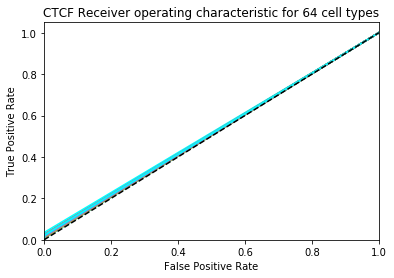

In [406]:

# Plot all ROC curves
plt.figure()


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for cell, color in zip(CTCF_FPR.keys(), colors):
    plt.plot(CTCF_FPR[cell], CTCF_TPR[cell], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cell, CTCF_AUC[cell]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CTCF Receiver operating characteristic for 64 cell types')
# plt.legend(loc="lower right")
plt.show()

In [152]:
a = pybedtools.example_bedtool('a.bed')
b = pybedtools.example_bedtool('b.bed')
print(a)
print(b)

chr1	1	100	feature1	0	+
chr1	100	200	feature2	0	+
chr1	150	500	feature3	0	-
chr1	900	950	feature4	0	+

chr1	155	200	feature5	0	-
chr1	800	901	feature6	0	+



In [153]:

print(a.window(b, w=0)) 

chr1	100	200	feature2	0	+	chr1	155	200	feature5	0	-
chr1	150	500	feature3	0	-	chr1	155	200	feature5	0	-
chr1	900	950	feature4	0	+	chr1	800	901	feature6	0	+

